In [4]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

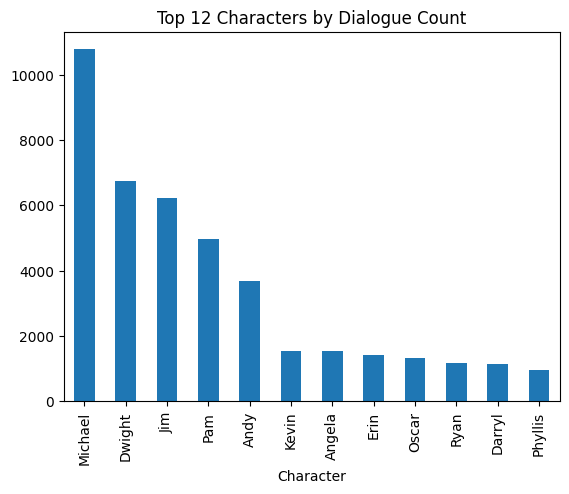

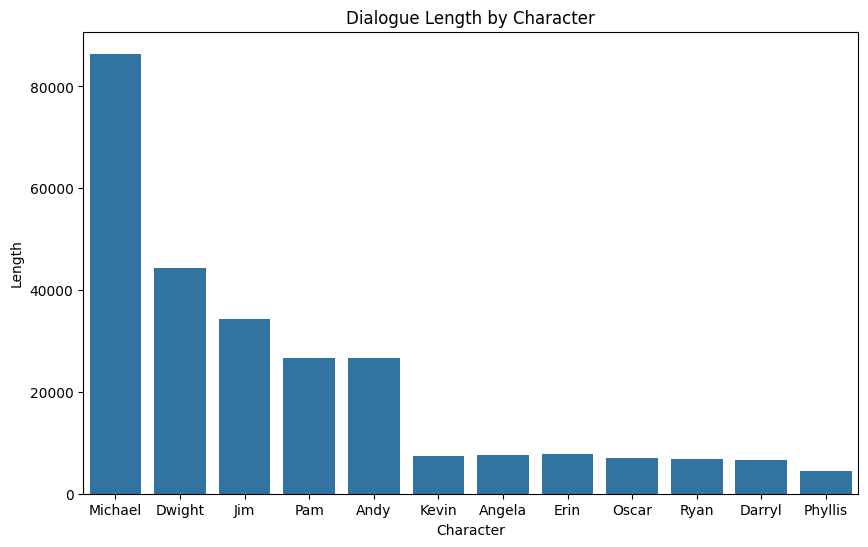

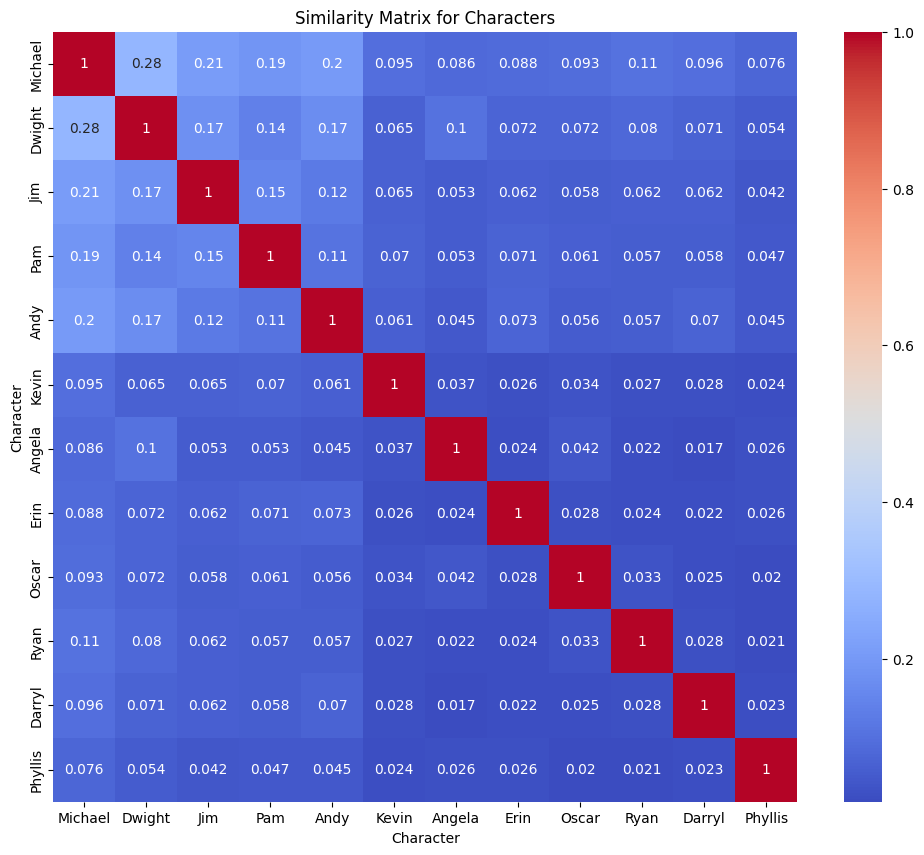

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/60
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.4404 - loss: 1.0649 - val_accuracy: 0.4762 - val_loss: 0.9987
Epoch 2/60
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5481 - loss: 0.9258 - val_accuracy: 0.5175 - val_loss: 0.9644
Epoch 3/60
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6678 - loss: 0.7281 - val_accuracy: 0.5095 - val_loss: 1.0164
Epoch 4/60
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7443 - loss: 0.5747 - val_accuracy: 0.5053 - val_loss: 1.1165
Epoch 5/60
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7886 - loss: 0.4737 - val_accuracy: 0.5074 - val_loss: 1.2610
Epoch 6/60
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8215 - loss: 0.4048 - val_accuracy: 0.5019 - val_loss: 1.4476
Epoch 7/60
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8400 - loss: 0.3629 - val_accuracy: 0.5019 - val_loss: 1.5478
Epoch 8/60
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8515 - loss: 0.3333 - val_accuracy: 0.4998 - v

In [6]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import gensim
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer

data1 = "theoffice.csv"
dat = data1
df = pd.read_csv(dat)
df.dropna(subset=['Dialogue'], inplace=True)
df["Character"].value_counts().head(12).plot(kind="bar")
plt.title("Top 12 Characters by Dialogue Count")
plt.show()

def datlistcor_creator(name):
    st = ""
    for i in df["Dialogue"][df["Character"] == name]:
        st += i
    return st

datlistcor_df = pd.DataFrame()
datlistcor_df["Character"] = list(df["Character"].value_counts().head(12).index)
datlistcor_df["Dialogues"] = [datlistcor_creator(i) for i in datlistcor_df["Character"]]

from sklearn.feature_extraction import text
punc = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}', "%"]
stop_words = text.ENGLISH_STOP_WORDS.union(punc)

def tproc(dialogue):
    dialogue = word_tokenize(dialogue)
    nopunc = [word.lower() for word in dialogue if word not in stop_words]
    return nopunc

datlistcor_df["Dialogues"] = datlistcor_df["Dialogues"].apply(lambda x: tproc(x))
datlistcor_df["Length"] = datlistcor_df["Dialogues"].apply(len)

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(ax=ax, y="Length", x="Character", data=datlistcor_df)
plt.title("Dialogue Length by Character")
plt.show()

dictionary = gensim.corpora.Dictionary(datlistcor_df["Dialogues"])
datlistcor = [dictionary.doc2bow(bw) for bw in datlistcor_df["Dialogues"]]
tf_idf = gensim.models.TfidfModel(datlistcor)
sims = gensim.similarities.Similarity('', tf_idf[datlistcor], num_features=len(dictionary))

sim_list = []
for i in range(12):
    query = dictionary.doc2bow(datlistcor_df["Dialogues"][i])
    query_tf_idf = tf_idf[query]
    sim_list.append(sims[query_tf_idf])

corr_df = pd.DataFrame(sim_list, columns=datlistcor_df["Character"])
corr_df.index = datlistcor_df["Character"]

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr_df, ax=ax, annot=True, cmap="coolwarm")
plt.title("Similarity Matrix for Characters")
plt.show()

top_characters = datlistcor_df.nlargest(3, "Length")["Character"].tolist()
df = df[df['Character'].isin(top_characters)]
X = df["Dialogue"]
y = df["Character"]

labelencoder_y = LabelEncoder()
y = labelencoder_y.fit_transform(y)
y = np.expand_dims(y, axis=1)

onehotencoder = OneHotEncoder()
y = onehotencoder.fit_transform(y).toarray()

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_matrix(X, mode="tfidf")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)

input_dim = X.shape[1]
num_classes = y.shape[1]

model = Sequential([
    Dense(512, input_shape=(input_dim,), activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=60, batch_size=256, validation_data=(X_test, y_test))


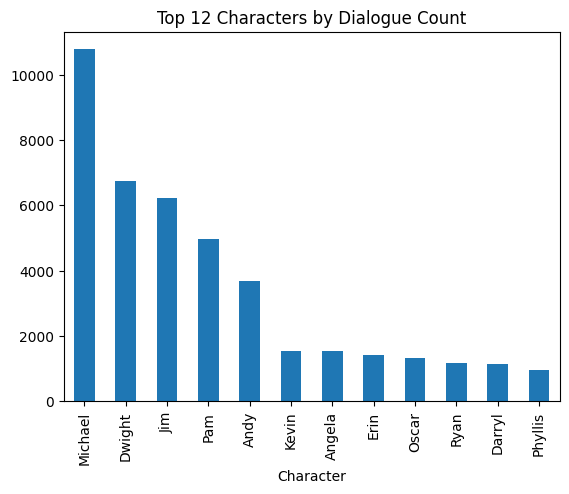

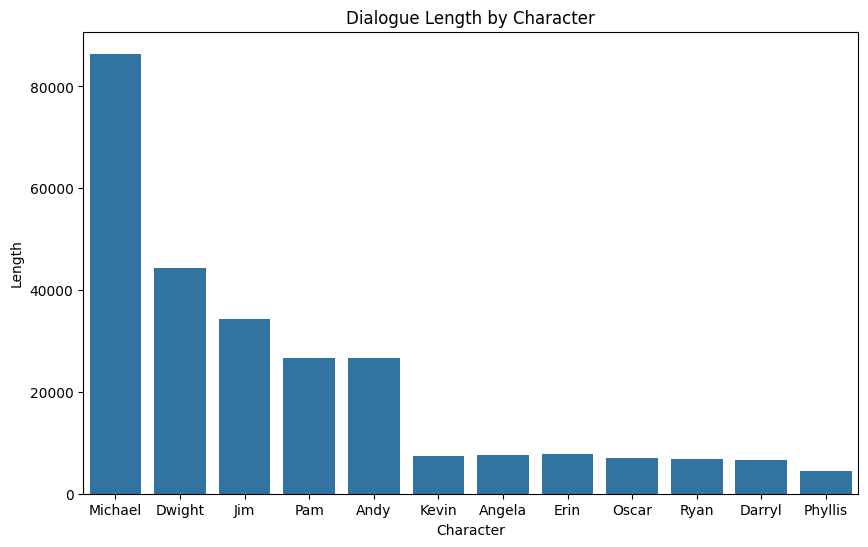

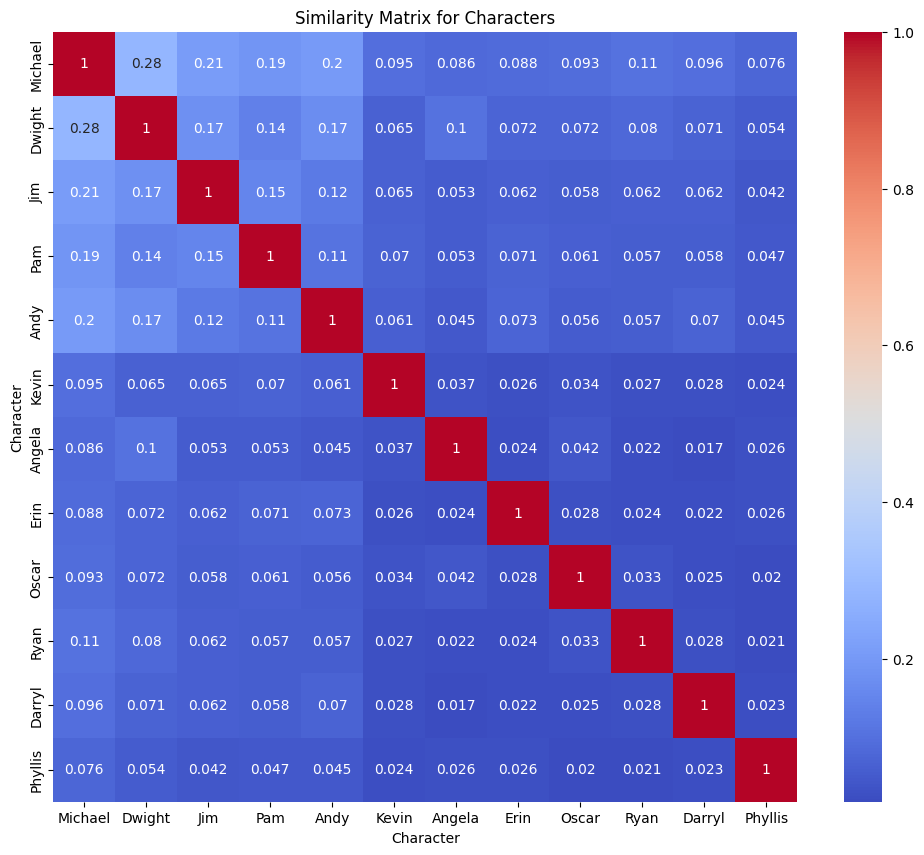

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


[[382 165 149]
 [175 309 166]
 [343 261 425]]
              precision    recall  f1-score   support

      Dwight       0.42      0.55      0.48       696
         Jim       0.42      0.48      0.45       650
     Michael       0.57      0.41      0.48      1029

    accuracy                           0.47      2375
   macro avg       0.47      0.48      0.47      2375
weighted avg       0.49      0.47      0.47      2375

Before Vectorization: ['Jan is about to have a baby with a sperm donor. And, Michael is preparing for the birth of a watermelon with Dwight. Now, this baby will be related to Michael through delusion.']
After Vectorization:   (0, 770)	0.1255109223460429
  (0, 1186)	0.40278668139288165
  (0, 1552)	0.2710000345947499
  (0, 3618)	0.31473352082074135
  (0, 3990)	0.30565800244175073
  (0, 4195)	0.1437782402598178
  (0, 6884)	0.18774558257411655
  (0, 8040)	0.2958086789840547
  (0, 8697)	0.18609927643489624
  (0, 9788)	0.32752474555474637
  (0, 10422)	0.2880037797601044
  

In [9]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.naive_bayes import MultinomialNB as MNB
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import VotingClassifier as VC
from sklearn.neural_network import MLPClassifier
import gensim

data1 = "theoffice.csv"
df = pd.read_csv(data1)
df.dropna(subset=['Dialogue'], inplace=True)
df["Character"].value_counts().head(12).plot(kind="bar")
plt.title("Top 12 Characters by Dialogue Count")
plt.show()

def datlistcor_creator(name):
    return "".join(df["Dialogue"][df["Character"] == name])

datlistcor_df = pd.DataFrame()
datlistcor_df["Character"] = list(df["Character"].value_counts().head(12).index)
datlistcor_df["Dialogues"] = [datlistcor_creator(i) for i in datlistcor_df["Character"]]

punc = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}', "%"]
stop_words = text.ENGLISH_STOP_WORDS.union(punc)

def tproc(dialogue):
    dialogue = word_tokenize(dialogue)
    return [word.lower() for word in dialogue if word not in stop_words]

datlistcor_df["Dialogues"] = datlistcor_df["Dialogues"].apply(lambda x: tproc(x))
datlistcor_df["Length"] = datlistcor_df["Dialogues"].apply(len)

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(ax=ax, y="Length", x="Character", data=datlistcor_df)
plt.title("Dialogue Length by Character")
plt.show()

dictionary = gensim.corpora.Dictionary(datlistcor_df["Dialogues"])
datlistcor = [dictionary.doc2bow(bw) for bw in datlistcor_df["Dialogues"]]
tf_idf = gensim.models.TfidfModel(datlistcor)
sims = gensim.similarities.Similarity('', tf_idf[datlistcor], num_features=len(dictionary))

sim_list = []
for i in range(12):
    query = dictionary.doc2bow(datlistcor_df["Dialogues"][i])
    sim_list.append(sims[tf_idf[query]])

corr_df = pd.DataFrame(sim_list, columns=datlistcor_df["Character"])
corr_df.index = datlistcor_df["Character"]

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr_df, ax=ax, annot=True, cmap="coolwarm")
plt.title("Similarity Matrix for Characters")
plt.show()

datlistcor_df['Dialogue_Length'] = datlistcor_df['Dialogues'].apply(len)
top_10_characters_list = datlistcor_df.nlargest(3, "Dialogue_Length")["Character"].tolist()
df = df[df['Character'].isin(top_10_characters_list)]
X, y = df["Dialogue"], df["Character"]

def ptextor(dialogue):
    return [word.lower() for word in word_tokenize(dialogue) if word not in stop_words]

vectorizer = TfidfVectorizer(analyzer=ptextor).fit(X)
X = vectorizer.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)
undersample = RandomUnderSampler(random_state=42)
X_train, y_train = undersample.fit_resample(X_train, y_train)

mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=200, alpha=0.2, solver='adam', verbose=10, random_state=42, tol=1e-4)
mnb = MNB(alpha=10)
lor = LR(random_state=101)
rf = RFC(n_estimators=80, criterion="entropy", random_state=42, n_jobs=-1)
vcf = VC(estimators=[('mlp', mlp)], voting='hard')

rf.fit(X_train, y_train)
predict = rf.predict(X_test)

print(confusion_matrix(y_test, predict))
print(classification_report(y_test, predict))

def predic(s):
    print("Before Vectorization:", s)
    s = vectorizer.transform(s)
    print("After Vectorization:", s)
    print(rf.predict(s))

predic(["Jan is about to have a baby with a sperm donor. And, Michael is preparing for the birth of a watermelon with Dwight. Now, this baby will be related to Michael through delusion."])


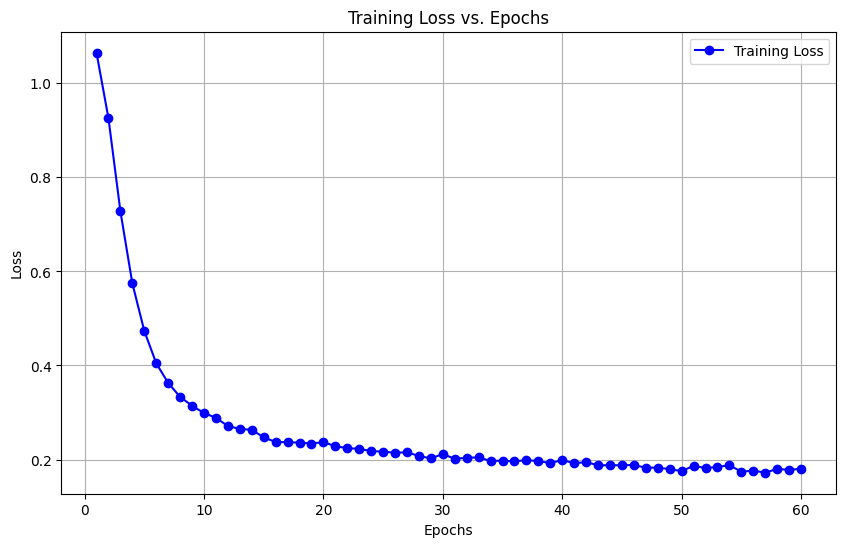

In [10]:
import matplotlib.pyplot as plt

# Extracted training loss values for each epoch
epochs = list(range(1, 61))  # From Epoch 1 to 60
training_loss = [
    1.0649, 0.9258, 0.7281, 0.5747, 0.4737, 0.4048, 0.3629, 0.3333, 0.3144, 0.2989,
    0.2888, 0.2712, 0.2652, 0.2631, 0.2474, 0.2372, 0.2370, 0.2359, 0.2341, 0.2370,
    0.2285, 0.2241, 0.2229, 0.2178, 0.2170, 0.2143, 0.2156, 0.2075, 0.2024, 0.2117,
    0.2016, 0.2038, 0.2046, 0.1969, 0.1978, 0.1961, 0.1989, 0.1967, 0.1925, 0.1990,
    0.1923, 0.1944, 0.1880, 0.1877, 0.1880, 0.1883, 0.1827, 0.1828, 0.1797, 0.1753,
    0.1867, 0.1819, 0.1842, 0.1880, 0.1741, 0.1766, 0.1720, 0.1802, 0.1780, 0.1805
]

# Plotting training loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, label='Training Loss', color='blue', marker='o', linestyle='-')

# Adding labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epochs')
plt.grid(True)
plt.legend()

# Display the plot
plt.show()
